This is my first Kaggle Competition Submission (7th attempt), where I use SVM to predict the survival rate of Titanic passengers.

This submission has an accuracy score of 0.78229, and ranked #2474 at the time of submission (Oct. 16th, 2022).

# 1. Load Packages and Data

In [1]:
import numpy as np 
import pandas as pd 
import re as re
import matplotlib.pyplot as plt
%matplotlib inline

train_df = pd.read_csv('../input/titanic/train.csv')
test_df = pd.read_csv('../input/titanic/test.csv')

In [2]:
#Display the training and testing datasets
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# 2. Handle Missing Values

In [4]:
#Check whether the datasets contain missing values.
train_df.isnull().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

In [5]:
#Check missing values in test_df
test_df.isnull().any()

PassengerId    False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare            True
Cabin           True
Embarked       False
dtype: bool

The training set has missing values in the columns 'Age', 'Cabin', 'Embarked'. The testing set has missing values in the columns 'Age', 'Fare', 'Cabin'. Let's check what are the percentages of missing values in these columns.

In [6]:
train_df[['Age','Cabin','Embarked']].isnull().sum() * 100 / len(train_df)

Age         19.865320
Cabin       77.104377
Embarked     0.224467
dtype: float64

In [7]:
test_df[['Age','Cabin','Embarked']].isnull().sum() * 100 / len(test_df)

Age         20.574163
Cabin       78.229665
Embarked     0.000000
dtype: float64

In both datasets, more than 77% of the values in the 'Cabin' columns are missing, *so I will drop 'Cabin' in the data cleaning step.* In the remainder of this section, I fill in the missing values in 'Age', 'Embarked' and 'Fare' in the respective dataset.


In [8]:
#1. Fill in missing 'Age' using random values based on the distribution of 'Age'
all_df = [train_df, test_df]
for data in all_df:
    mean = data['Age'].mean()
    std = data['Age'].std()
    is_null = data['Age'].isnull().sum()
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)

    age = data['Age'].copy()
    age[np.isnan(age)] = rand_age
    data['Age'] = age
    data['Age'] = data['Age'].astype(int)

In [9]:
#For train_df, fill in missing 'Embarked' using mode
train_df['Embarked'] = train_df['Embarked'].fillna(train_df['Embarked'].mode()[0])

Since 'Fare' may be correlated with 'Pclass', we will deal with it in Section 3.f Fares.

# 3. Feature Engineering

In this step, I will check whether the other columns are correlated to the passenger's survival.

## a. Pclass

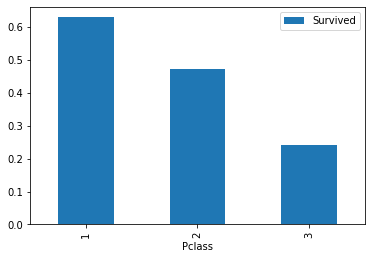

In [10]:
train_df[['Pclass', 'Survived']].groupby('Pclass').mean().plot(kind='bar');

## b. Sex

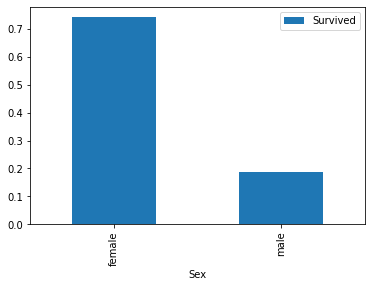

In [11]:
train_df[['Sex', 'Survived']].groupby('Sex').mean().plot(kind='bar');

## b. Name

A quick glance over the first 5 rows in the datasets shows that the 'Name' columns also contain passenger titles, so we check whether the titles have impacts the survival.

In [12]:
#Use regex to extract title 
def get_title(name):
    find_title = re.search('([A-Z][a-z]+)\.', name)
    if find_title:
        return find_title.group(1)
    else:
        return ''

#Replace 'Name' column by 'Title' column.
train_df['Title'] = train_df['Name'].apply(get_title)
train_df = train_df.drop('Name', axis = 1)
test_df['Title'] = test_df['Name'].apply(get_title)
test_df = test_df.drop('Name', axis = 1)


In [13]:
train_df[['Title','Sex']].value_counts()

Title     Sex   
Mr        male      517
Miss      female    182
Mrs       female    125
Master    male       40
Rev       male        6
Dr        male        6
Mlle      female      2
Major     male        2
Col       male        2
Ms        female      1
Mme       female      1
Capt      male        1
Lady      female      1
Jonkheer  male        1
Dr        female      1
Don       male        1
Countess  female      1
Sir       male        1
dtype: int64

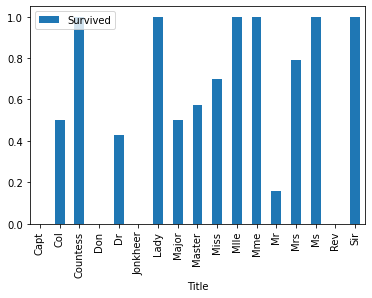

In [14]:
train_df[['Title', 'Survived']].groupby('Title').mean().plot(kind='bar');

In [15]:
test_df[['Title','Sex']].value_counts()

Title   Sex   
Mr      male      240
Miss    female     78
Mrs     female     72
Master  male       21
Col     male        2
Rev     male        2
Dona    female      1
Dr      male        1
Ms      female      1
dtype: int64

We replace titles by their respect mean survival rate.

In [16]:
title_df = train_df[['Title', 'Survived']].groupby('Title').mean()

In [17]:
title_dict = {}
for i in range(len(list(title_df.index))):
    title_dict[list(title_df.index)[i]] = title_df.iloc[i,0]
title_dict['Dona']=0

all_df = [train_df, test_df]
for data in all_df:
    data['Title']=data['Title'].replace(title_dict)

## d. SibSp

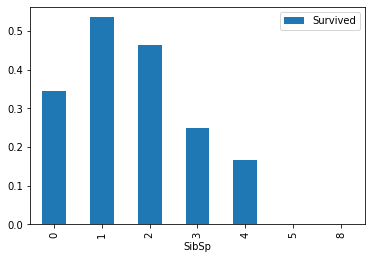

In [18]:
train_df[['SibSp', 'Survived']].groupby('SibSp').mean().plot(kind='bar');

## e. Parch

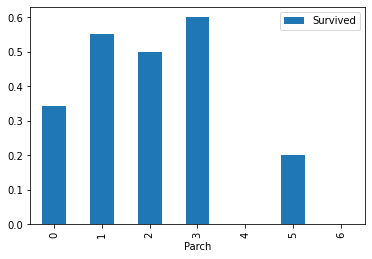

In [19]:
train_df[['Parch', 'Survived']].groupby('Parch').mean().plot(kind='bar');

## f. Fare

First, we check whether Fare is correlated with Pclass.

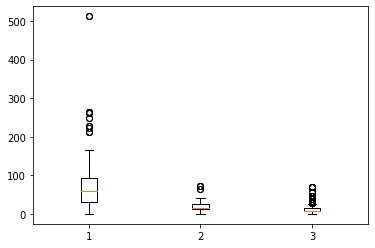

In [20]:
fig = plt.figure()
ax = plt.subplot(111)
for i in range(1,4):
    ax.boxplot(train_df.loc[(train_df['Pclass']==i)][['Fare']], positions = [i])

In [21]:
for i in range(1,4):
    print(test_df.loc[(test_df['Pclass']==i)][['Fare']].isnull().any())
test_df["Fare"].isnull().sum()

Fare    False
dtype: bool
Fare    False
dtype: bool
Fare    True
dtype: bool


1

Indeed, there seems to be a correlation between Fare and Pclass. Moreover, the only missing value in 'Fare' shows up when 'Pclass' is 3. So we replace the missing value by the mean fare prices for Pclass == 3.

In [22]:
mean = test_df.loc[(test_df['Pclass']==3)][['Fare']].mean()[0]
test_df['Fare'] = test_df['Fare'].fillna(value=mean)

## g. Embarked
Note that we have already filled in the missing values in this column. So we check the mean survival rate on the original data and the modified data respectively.

<AxesSubplot:xlabel='Embarked'>

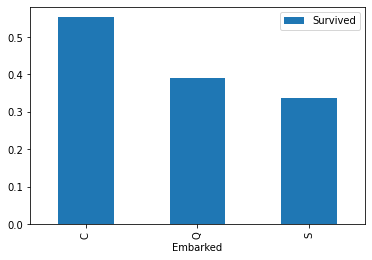

In [23]:
pd.read_csv('../input/titanic/train.csv')[['Embarked', 'Survived']].groupby('Embarked').mean().plot(kind='bar')

<AxesSubplot:xlabel='Embarked'>

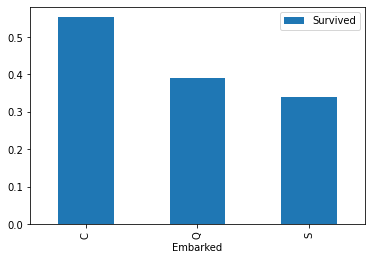

In [24]:
train_df[['Embarked', 'Survived']].groupby('Embarked').mean().plot(kind='bar')

There's no significant difference. It seems to have been a good idea to fill in the missing values by the mode.

# 3. Data Cleaning

Now we are ready to drop the unnecessary columns: 'PassengerId', 'Ticket', 'Cabin'.

In [25]:
train_df = train_df.drop(['PassengerId','Ticket','Cabin'], axis=1)
test_df = test_df.drop(['PassengerId','Ticket','Cabin'], axis=1)
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,male,22,1,0,7.2500,S,0.156673
1,1,1,female,38,1,0,71.2833,C,0.792000
2,1,3,female,26,0,0,7.9250,S,0.697802
3,1,1,female,35,1,0,53.1000,S,0.792000
4,0,3,male,35,0,0,8.0500,S,0.156673


Finally, let's encode the categorical data.

In [26]:
#Encode categorical data
train_df['Embarked'] = train_df['Embarked'].astype('category').cat.codes
test_df['Embarked'] = test_df['Embarked'].astype('category').cat.codes
train_df['Sex'] = train_df['Sex'].astype('category').cat.codes
test_df['Sex'] = test_df['Sex'].astype('category').cat.codes

# 4. Train and Predict

In [27]:
X_train = train_df.drop("Survived", axis=1)
y_train = train_df["Survived"]
X_test  = test_df

In [28]:
#Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [29]:
#Train model using SVM
from sklearn.svm import SVC
model = SVC()
model.fit(X_train, y_train) 
y_pred = model.predict(X_test)

In [30]:
#Check model accuracy
from sklearn.metrics import accuracy_score
model.score(X_train, y_train)
model = round(model.score(X_train, y_train) * 100, 2)
model

84.4

In [31]:
#Train model using random forest and check accuracy
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=7, random_state=42)
clf.fit(X_train, y_train)
y_pred_1 = clf.predict(X_test)
clf.score(X_train, y_train)

0.8855218855218855

# 5. Create Submission File

In [32]:
submission = pd.DataFrame({
        "PassengerId": pd.read_csv('../input/titanic/test.csv')["PassengerId"],
        "Survived": y_pred
    })
submission.to_csv('./submission.csv', index=False)